# Read Gamma + Muon Simulations and Fit to Lab Data + Smear (vz5)
#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

This notebook imports the Geant4 simulated gamma + muon backgrounds and then applies a normal distribution transformation to the data in order to "smear" it so that it matches lab data. $\chi^2/\text{ndf}$ is calculated and is improved by normalizing gamma lines/muon flux.

The smeared simulated data energy deposited $R$ can mathematically be described as a normal distirbution:

$$R\sim\mathcal{N}(E_{PE},\sigma^2)$$

where $E_{PE}$ is the energy deposited in units of PE and $\sigma$ is the energy resolution function (also in units of PE) which this notebook is attempting to model. Therefore, $R$ has values in PE and since both the lab and simulated data to be imported have units of MeV, a conversion is necessary using the pe_mev constant calculated in $\texttt{readDataAndFit-AndrewUpdate-Copy1.ipynb}$

The energy resolution function $\sigma$ has been modeled in literature previously as having the form:
$$ \sigma^2 = c_0 + c_1 E_{PE} + c_2 E_{PE}^2 $$

where $c_1$, $c_2$, $c_3$ are scalars that need to be determined by minimizing the $\chi^2/\text{ndf}$ between the smeared simulated data and the lab data. Before doing this however, the notebook attempts to model $\sigma$ as a constant and as linearly scaled, which are found to be good approximations (more explanation on the individual models later).

### Import needed libraries

In [1]:
import numpy as np

import ROOT
from ROOT import *
import ctypes
from ctypes import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
from scipy.optimize import *
import pandas as pd
import seaborn as sns

from datetime import datetime
from glob import glob

%cd libs/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file 
                                 # named dt5202.py in the lib folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.22/00
/home/coure/Din_SmearingProject_Summer2023/libs
/home/coure/Din_SmearingProject_Summer2023


### Declare constants

In [2]:
ped = 50 # Pedestal correction for dt5202

# Declare constants for conversion from ADC to PE/MeV
adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

sig662 = 0.1601 # Get the sigma in [MeV] from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"

### Import simulated .ROOT files and lab data

In [3]:
%%capture

%cd libs/
%run ImportData_LabAndSimulation_Din_vzd1.ipynb # This notebook imports both lab and simulated data and concatenates
                                                # it to arrays. A sim_root TH1 object is also declared and filled 
                                                # with the simulated data in [MeV].
%cd -

In [4]:
# Concatenate the energies into np arrays
g_mev = np.concatenate((energyDeposited1460,energyDeposited2614,
                        energyDeposited1120,energyDeposited1238,
                        energyDeposited1764,energyDeposited2204,
                        energyDeposited968,energyDeposited934,
                        energyDeposited911,energyDeposited609,
                        energyDeposited583)) # individually simulated gamma lines
mu_mev = np.array(muonsEnergy) # muons [MeV]
sim_mev = np.concatenate((g_mev, mu_mev)) # full spectrum [PE]

# Convert the energies from [MeV] to [PE]
sim_pe = sim_mev * pe_mev # Simulated data in [PE]
g_pe = g_mev * pe_mev # Simulated gammas in [PE]
mu_pe = mu_mev * pe_mev # Simulated muons in [PE]

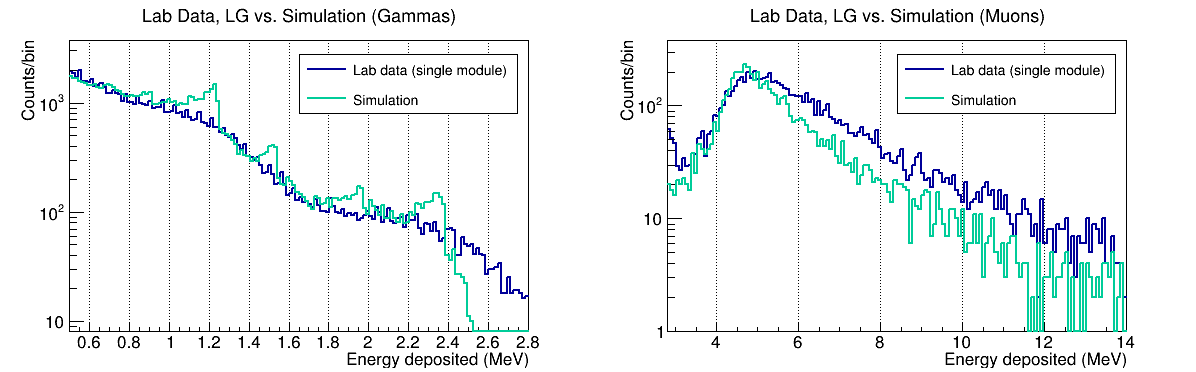

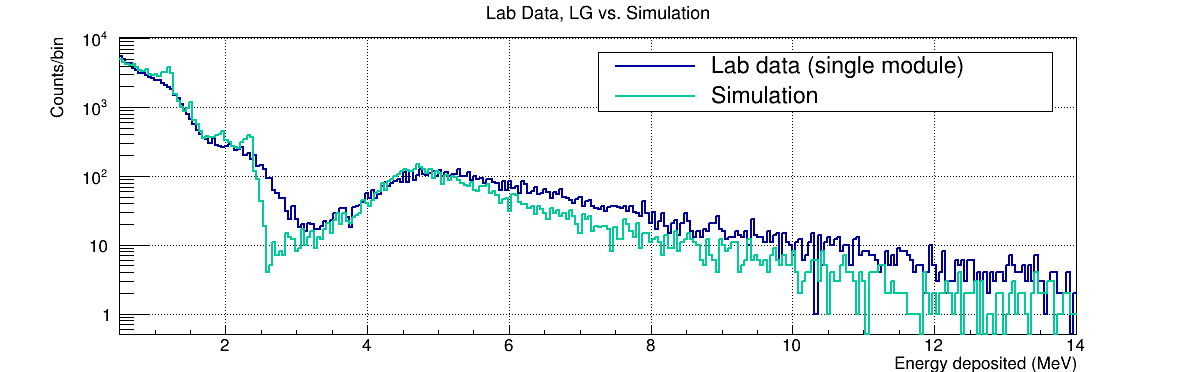

In [5]:
# Plot imported lab data vs simulation

c1_1 = TCanvas('c1_1','',1200,400)
c1_1.cd()

lab_root = TH1D('lab_root','',300,0.5,14) # Lab data [MeV]
fill_hist(lab_root, lab_mev)
sim_root.Reset() # Simulated data [MeV], object already declared in imported notebook
fill_hist(sim_root, sim_mev)

gStyle.SetPalette(kBird) # Colorblind-friendly palette

lab_g = TH1D('lab_g','',150,0.5,2.8) # Lab data, gammas [MeV]
fill_hist(lab_g, lab_mev)
lab_mu = TH1D('lab_mu','',150,2.8,14) # Lab data, muons [MeV]
fill_hist(lab_mu, lab_mev)
sim_g = TH1D('sim_g','',150,0.5,2.8) # Simulated data, gammas [MeV]
fill_hist(sim_g, g_mev)
sim_mu = TH1D('sim_mu','',150,2.8,14) # Simulated data, muons [MeV]
fill_hist(sim_mu, mu_mev)

c1_1.Divide(2,0)

c1_1.cd(1) # Plot gamma part of spectrum only

lab_g.Draw()
lab_g.SetTitle("Lab Data, LG vs. Simulation (Gammas)")
lab_g.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_g.GetXaxis().SetLabelSize(.05)
lab_g.GetXaxis().SetTitleSize(.05)
lab_g.GetYaxis().SetTitle("Counts/bin")
lab_g.GetYaxis().SetLabelSize(.05)
lab_g.GetYaxis().SetTitleSize(.05)
lab_g.GetYaxis().SetTitleOffset(.9)
lab_g.SetLineColor(kBlue+2)
lab_g.SetLineWidth(2)

sim_g.Draw("same")
sim_g.SetLineWidth(2)
sim_g.SetLineColor(kTeal-1)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend = TLegend(0.5,0.7,0.88,0.86)
legend.AddEntry(lab_g,"Lab data (single module)","l")
legend.AddEntry(sim_g,"Simulation","l")
legend.Draw()

c1_1.cd(2) # Plot muon part of spectrum only

lab_mu.Draw()
lab_mu.SetTitle("Lab Data, LG vs. Simulation (Muons)")
lab_mu.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_mu.GetXaxis().SetLabelSize(.05)
lab_mu.GetXaxis().SetTitleSize(.05)
lab_mu.GetYaxis().SetTitle("Counts/bin")
lab_mu.GetYaxis().SetLabelSize(.05)
lab_mu.GetYaxis().SetTitleSize(.05)
lab_mu.GetYaxis().SetTitleOffset(.9)
lab_mu.SetLineWidth(2)
lab_mu.SetLineColor(kBlue+2)

sim_mu.Draw("same")
sim_mu.SetLineWidth(2)
sim_mu.SetLineColor(kTeal-1)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend2 = TLegend(0.5,0.7,0.88,0.86)
legend2.AddEntry(lab_g,"Lab data (single module)","l")
legend2.AddEntry(sim_g,"Simulation","l")
legend2.Draw()

# Plot full spectrum
c1_2 = TCanvas('c2_2','',1200,400)
c1_2.cd()

lab_root.Draw()
lab_root.SetTitle("Lab Data, LG vs. Simulation")
lab_root.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_root.GetXaxis().SetLabelSize(.05)
lab_root.GetXaxis().SetTitleSize(.05)
lab_root.GetYaxis().SetTitle("Counts/bin")
lab_root.GetYaxis().SetLabelSize(.05)
lab_root.GetYaxis().SetTitleSize(.05)
lab_root.GetYaxis().SetTitleOffset(.65)
lab_root.SetLineWidth(2)
lab_root.SetLineColor(kBlue+2)

sim_root.Draw("same") 
sim_root.SetLineWidth(2)
sim_root.SetLineColor(kTeal-1)

gPad.SetLogy()
gPad.SetGrid()
gStyle.SetOptStat(0)

legend3 = TLegend(0.5,0.7,0.88,0.86)
legend3.AddEntry(lab_g,"Lab data (single module)","l")
legend3.AddEntry(sim_g,"Simulation","l")
legend3.Draw()

c1_1.Draw()
c1_2.Draw()

# c1_1.SaveAs("NBv5_LabVsSimulation_GammasAndMuons.png")
# c1_2.SaveAs("NBv5_LabVsSimulation_FullSpectrum.png")

### ATTEMPT 1: Constant sigma model

In $\texttt{Cs137_GaussFitting_ForResolution_Din_vz1.ipynb}$ a value for $\sigma$ is gotten from fitting a gaussian to the Cs-137 compton maximum (approximated value). This $\sigma$ is denoted by sig662 in this notebook, because the Cs-137 peak is at 662 KeV and it is an estimation of the value of the resolution function at this energy.

sig662 is converted from MeV to PE units and is used as the 'first pass' test for sigma, the energy resolution function. Physically we do not expect the energy resolution of the single module to be the same for all energies and so the fit is not expected to be excellent.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



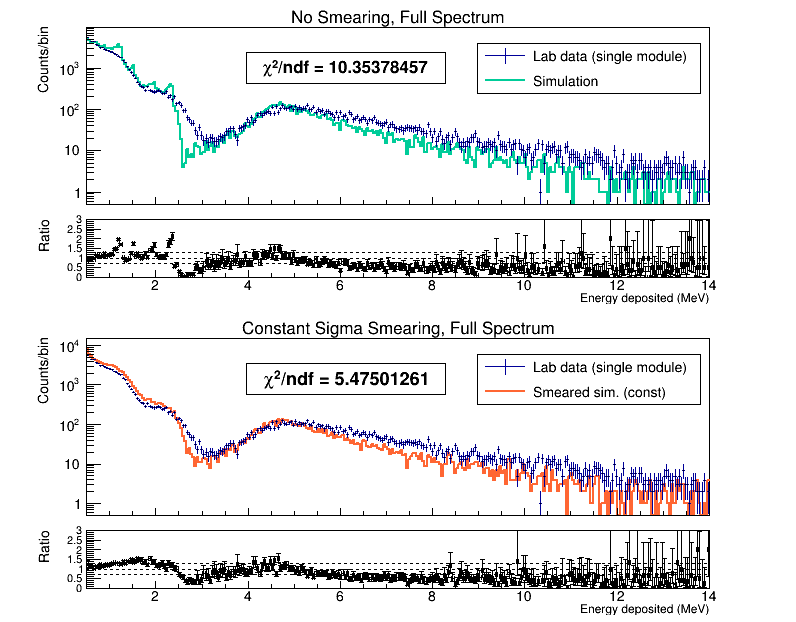

In [6]:
# Apply smearing in [PE] by treating the normal distribution scale as constant
bg_smeared = np.random.normal(loc=sim_pe, scale = sig662 * pe_mev)

# Declare a TH1 and fill it with the smeared data
const_smear = TH1D('const_smear','',300,0.5,14)
fill_hist(const_smear,bg_smeared/pe_mev)

# Create two plots, one with unsmeared vs. lab data, and the other with const. smear
# vs. lab data. Calculate chi2/ndf for both.

c2 = TCanvas('c2','',800,650)

gStyle.SetPalette(kBird) # Colorblind friendly palette

const_smear.Draw()

lab_root.SetLineColor(kBlue+2)
lab_root.SetLineWidth(1)
const_smear.SetLineColor(kOrange+8)
const_smear.SetLineWidth(2)

const_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
const_smear.GetXaxis().SetLabelSize(.05)
const_smear.GetXaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitle("Counts/bin")
const_smear.GetYaxis().SetLabelSize(.05)
const_smear.GetYaxis().SetTitleSize(.05)
const_smear.GetYaxis().SetTitleOffset(.9)

c2.Clear() # Erase what was drawn because a ratio plot will be made instead

gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)
c2.Divide(0,2)

c2.cd(1) # Unsmeared sim. vs. lab data

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)

rp1 = ROOT.TRatioPlot(sim_root,lab_root)
rp1.Draw()

sim_root.SetTitle("No Smearing, Full Spectrum")
sim_root.SetLineColor(kTeal-1)
sim_root.SetLineWidth(2)

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(sim_root.Chi2Test(lab_root, "UW CHI2/NDF"), 8)) + " "

c2.cd(2) # Const. smeared sim. vs. lab data

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)

rp2 = TRatioPlot(const_smear,lab_root)
rp2.Draw()

const_smear.SetTitle("Constant Sigma Smearing, Full Spectrum")

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetLowerRefYaxis().SetTitleOffset(1.1)
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(0,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(const_smear.Chi2Test(lab_root, "UW CHI2/NDF"), 8)) + " "

c2.cd()

# Create the legends. Probably not the best way to do this for symmetry, better if done
# within the individual cd()s.
legend1 = TLegend(0.6,0.85,0.88,0.93)
legend1.AddEntry(lab_root,"Lab data (single module)","le")
legend1.AddEntry(sim_root,"Simulation","l")
legend1.Draw()

legend2 = TLegend(0.6,0.35,0.88,0.43)
legend2.AddEntry(lab_root,"Lab data (single module)","le")
legend2.AddEntry(const_smear,"Smeared sim. (const)","l")
legend2.Draw()

# Show the calculated chi2/ndf values on both plots.
title1 = TPaveText(.31,.865,.56,.915)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

title2 = TPaveText(.31,.365,.56,.415)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c2.Draw()
# c2.SaveAs("NBv5_ConstVsNoSmearing_Full.png")

### ATTEMPT 2: Linearly scaled sigma model, comparison with const. sigma model

$\sigma^2$ is attempted to be modeled using the assumption that is scales linearly with energy (in PE). By this assumption, the following mathematical relationship is used to extrapolate the value of $\sigma$ at 1 PE:

$$\sigma_{1\text{PE}} = \frac{\sigma_{662\text{KeV}}}{0.662} \text{PE}$$

where $\sigma_{662\text{KeV}}$ is denoted by the previously-declared sig662 constant. Different smearing is applied to muons and gammas, the muons having an additional $x$-axis displacement of +16 PE. Moreover, because $\sigma^2$ is linear, the scale of the Normal distribution will take the form:

$$\text{scale} = a \sqrt{\sigma_{1\text{PE}} E_{PE}}$$

where $a$ is a scalar value.

In [7]:
sig1pe = (sig662*pe_mev) / (.662*pe_mev) # Assuming that sigma scales linearly, calculate its
                                         # value at 1 PE based on the value of sig662.

# Calculate the coefficient for the square root fn that will ensure sigma has value of sig662 at .662 KeV
# Denote this scalar by 'a'

a = (sig662*pe_mev) / np.sqrt(sig1pe*.662*pe_mev)

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



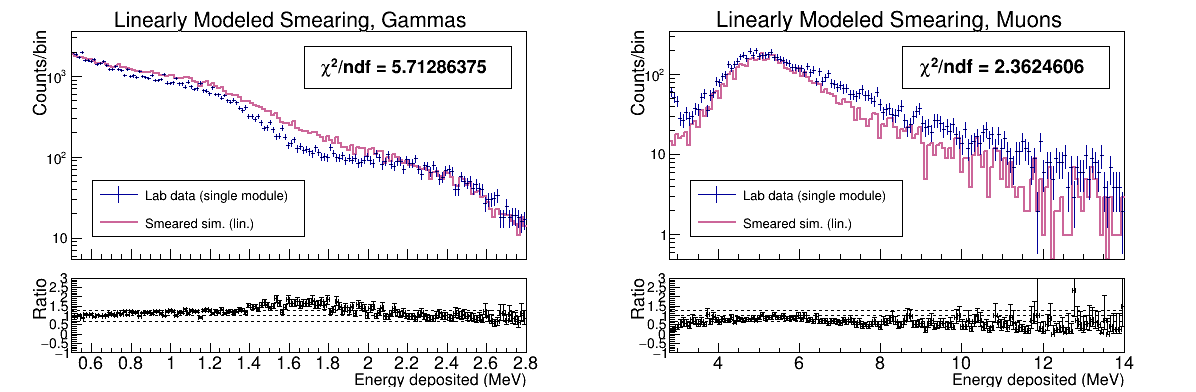

In [8]:
c3 = TCanvas('c3','',1200,420)

c3.cd()

# Part 1: Apply linear smearing to gammas
bg_smeared_lin_g_pe = np.random.normal(loc=g_pe, scale = a*np.power(sig1pe * g_pe, 0.5)) # [PE]

smeared_lin_g_th = TH1D('smeared1', 'Linearly Modeled Smearing, Gammas', 150, 0.5, 2.8) # TH1 object for 
                                                                                        # smeared gammas
fill_hist(smeared_lin_g_th, bg_smeared_lin_g_pe/pe_mev) # Convert bg_smeared_lin_g_pe from [PE] to [MeV]

smeared_lin_g_th.SetLineColor(ROOT.kPink + 2)
smeared_lin_g_th.SetLineWidth(2)

smeared_lin_g_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_g_th.GetYaxis().SetTitle("Counts/bin")

lab_g.SetLineColor(kBlue+2)
lab_g.SetLineWidth(1)

# Part 2: Apply linear smearing to muons
bg_smeared_lin_mu_pe = np.random.normal(loc=mu_pe, scale = a*np.power(sig1pe * mu_pe, 0.5)) + 16 # [PE]

smeared_lin_mu_th = ROOT.TH1D('smeared2', 'Linearly Modeled Smearing, Muons', 150, 2.8, 14) # TH1 object for
                                                                                            # smeared muons
fill_hist(smeared_lin_mu_th, bg_smeared_lin_mu_pe/pe_mev)

smeared_lin_mu_th.SetLineColor(ROOT.kPink + 2)
smeared_lin_mu_th.SetLineWidth(2)

smeared_lin_mu_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_mu_th.GetYaxis().SetTitle("Counts/bin")

lab_mu.SetLineColor(kBlue+2)
lab_mu.SetLineWidth(1)

c3.Clear() # Clear everything so that TRatioPlots can be drawn

c3.Divide(2,0)

c3.cd(1) # Subplot 1, draw gammas

gPad.SetLogy()
gStyle.SetStatFontSize(.08)
gStyle.SetTitleFontSize(0.085)
gStyle.SetStatW(0.4)

rp01 = TRatioPlot(smeared_lin_g_th,lab_g)
rp01.Draw()

rp01.GetLowerRefYaxis().SetTitle("Ratio")
rp01.GetUpperRefYaxis().SetTitle("Counts/bin")
rp01.GetUpperRefYaxis().SetTitleOffset(0.7)
rp01.GetLowerRefYaxis().SetTitleOffset(0.7)
rp01.GetLowerRefYaxis().SetRangeUser(-1,3)

rp01.GetLowerRefYaxis().SetLabelSize(.04)
rp01.GetLowerRefYaxis().SetTitleSize(.05)

rp01.GetUpperRefYaxis().SetLabelSize(.04)
rp01.GetUpperRefYaxis().SetTitleSize(.05)

rp01.GetLowerRefXaxis().SetLabelSize(.05)
rp01.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(lab_g.Chi2Test(smeared_lin_g_th, "UW CHI2/NDF"), 8)) + " " 

# The SMART/BETTER way to do legends and titles from how it was done previously
# (The reason it's smarter is that now that it's within the cd'd TCanvas, I can
#  just copy paste the coordinates between cd'd TCanvases to ensure symmetry.)
legend1 = TLegend(0.14,0.395,0.51,0.54)
legend1.AddEntry(lab_g, "Lab data (single module)","le")
legend1.AddEntry(smeared_lin_g_th, "Smeared sim. (lin.)","l")
legend1.Draw()

title1 = TPaveText(0.51,0.78,0.87,0.89, "NDC")
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

c3.cd(2) # Subplot 2, draw muons

gPad.SetLogy()
gStyle.SetStatFontSize(.08)
gStyle.SetTitleFontSize(0.085)
gStyle.SetStatW(0.4)

rp02 = TRatioPlot(smeared_lin_mu_th,lab_mu)
rp02.Draw()

rp02.GetLowerRefYaxis().SetTitle("Ratio")
rp02.GetUpperRefYaxis().SetTitle("Counts/bin")
rp02.GetUpperRefYaxis().SetTitleOffset(0.7)
rp02.GetLowerRefYaxis().SetTitleOffset(0.7)
rp02.GetLowerRefYaxis().SetRangeUser(-1,3)

rp02.GetLowerRefYaxis().SetLabelSize(.04)
rp02.GetLowerRefYaxis().SetTitleSize(.05)

rp02.GetUpperRefYaxis().SetLabelSize(.04)
rp02.GetUpperRefYaxis().SetTitleSize(.05)

rp02.GetLowerRefXaxis().SetLabelSize(.05)
rp02.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(lab_mu.Chi2Test(smeared_lin_mu_th, "UW CHI2/NDF"), 8)) + " "

legend2 = TLegend(0.14,0.395,0.51,0.54)
legend2.AddEntry(lab_mu, "Lab data (single module)","le")
legend2.AddEntry(smeared_lin_mu_th, "Smeared sim. (lin.)","l")
legend2.Draw()

title2 = TPaveText(0.51,0.78,0.87,0.89, "NDC")
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c3.Draw()

# c3.SaveAs("NBv5_LinSmear_GammasAndMuons_Separated.png")

### Compare linear smearing chi2/ndf with unsmeared and const. smeared data

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



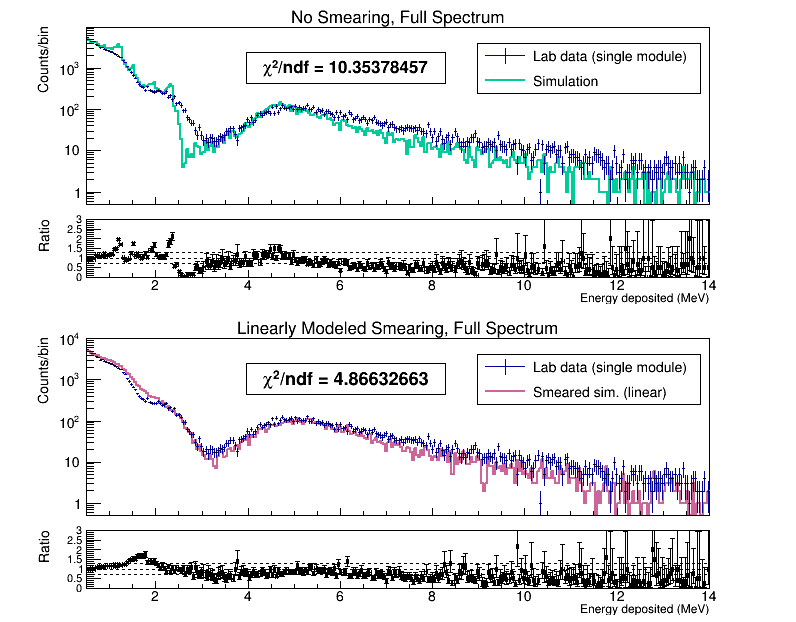

In [9]:
bg_smeared_lin_sim_pe = np.concatenate((bg_smeared_lin_g_pe, bg_smeared_lin_mu_pe)) # Concatenate arrays for full
                                                                                    # spectrum.

lin_smear = TH1D('lin_smear','',300,0.5,14) # Declare TH1 for full spectrum
fill_hist(lin_smear,bg_smeared_lin_sim_pe/pe_mev)

# Create two TRatioPlots, unsmeared sim. vs. lab data and lin. smear vs. lab data

c4 = TCanvas('c4','',800,650)
lin_smear.Draw()

lin_smear.GetXaxis().SetTitle("Energy deposited (MeV)")
lin_smear.GetXaxis().SetLabelSize(.05)
lin_smear.GetXaxis().SetTitleSize(.05)

lin_smear.GetYaxis().SetTitle("Counts/bin")
lin_smear.GetYaxis().SetLabelSize(.05)
lin_smear.GetYaxis().SetTitleSize(.05)
lin_smear.GetYaxis().SetTitleOffset(.9)

lin_smear.SetLineColor(kPink+2)
lin_smear.SetLineWidth(2)

c4.Clear()

gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)

gStyle.SetPalette(kBird)

c4.Divide(0,2)

c4.cd(1) # Unsmeared sim. vs. lab data

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)

rp1 = TRatioPlot(sim_root,lab_root)
rp1.Draw()

sim_root.SetTitle("No Smearing, Full Spectrum")

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetTitleOffset(0.7)

rp1.GetLowerRefYaxis().SetRangeUser(0,3)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(sim_root.Chi2Test(lab_root, "UW CHI2/NDF"), 8)) + " "

c4.cd(2) # Lin. smeared sim. vs lab data

gPad.SetLogy()
gStyle.SetOptStat(0)

rp2 = TRatioPlot(lin_smear,lab_root)
rp2.Draw()

lin_smear.SetTitle("Linearly Modeled Smearing, Full Spectrum")

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(0,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(lin_smear.Chi2Test(lab_root, "UW CHI2/NDF"), 8)) + " "

c4.cd()

# The bad way of doing TLegends and TPaveTexts, this code was copied from an old ver. of the nb
legend1 = TLegend(0.6,0.85,0.88,0.93)
legend1.AddEntry(lab_root,"Lab data (single module)","le")
legend1.AddEntry(sim_root,"Simulation","l")
legend1.Draw()

title1 = TPaveText(.31,.865,.56,.915)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

legend2 = TLegend(0.6,0.35,0.88,0.43)
legend2.AddEntry(lab_root,"Lab data (single module)","le")
legend2.AddEntry(lin_smear,"Smeared sim. (linear)","l")
legend2.Draw()

title2 = TPaveText(.31,.365,.56,.415)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c4.Draw()
# c4.SaveAs("NBv5_LinVsNoSmearing_Full.png")

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 1 points have been skipped
Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



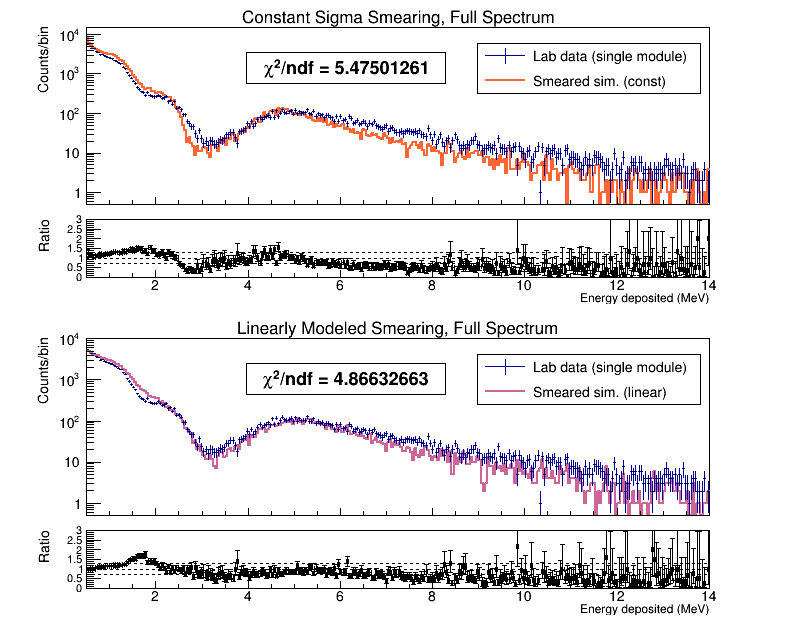

In [10]:
# Redo but with the two TRatioPlots being const. smearing vs. lab data and lin. smearing vs. lab data

c5 = TCanvas('c5','',800,650)

gStyle.SetStatFontSize(.08)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)

c5.Divide(0,2)

c5.cd(1) # Const. smeared sim. vs. lab data

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)

rp1 = TRatioPlot(const_smear,lab_root)
rp1.Draw()

rp1.GetLowerRefYaxis().SetTitle("Ratio")
rp1.GetUpperRefYaxis().SetTitle("Counts/bin")
rp1.GetUpperRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetTitleOffset(0.7)
rp1.GetLowerRefYaxis().SetRangeUser(0,3)

rp1.GetLowerRefYaxis().SetLabelSize(.04)
rp1.GetLowerRefYaxis().SetTitleSize(.05)
rp1.GetLowerRefXaxis().SetLabelSize(.05)
rp1.GetLowerRefXaxis().SetTitleSize(.045)

chi2_1 = " #chi^{2}/ndf = " + str(round(const_smear.Chi2Test(lab_root, "UW CHI2/NDF"), 8)) + " "

c5.cd(2) # Lin. smeared sim. vs lab data

gPad.SetLogy()
gStyle.SetOptStat(0)
gStyle.SetTitleFontSize(0.085)

rp2 = TRatioPlot(lin_smear,lab_root)
rp2.Draw()

lin_smear.SetTitle("Linearly Modeled Smearing, Full Spectrum")

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(0,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

chi2_2 = " #chi^{2}/ndf = " + str(round(lin_smear.Chi2Test(lab_root, "UW CHI2/NDF"), 8)) + " "

c5.cd()

legend1 = TLegend(0.6,0.85,0.88,0.93)
legend1.AddEntry(lab_root,"Lab data (single module)","le")
legend1.AddEntry(const_smear,"Smeared sim. (const)","l")
legend1.Draw()

title1 = TPaveText(.31,.865,.56,.915)
title1.AddText(chi2_1)
title1.SetMargin(0.05)
title1.SetBorderSize(1)
title1.SetFillColor(0)
title1.Draw()

legend2 = TLegend(0.6,0.35,0.88,0.43)
legend2.AddEntry(lab_root,"Lab data (single module)","le")
legend2.AddEntry(lin_smear,"Smeared sim. (linear)","l")
legend2.Draw()

title2 = TPaveText(.31,.365,.56,.415)
title2.AddText(chi2_2)
title2.SetMargin(0.05)
title2.SetBorderSize(1)
title2.SetFillColor(0)
title2.Draw()

c5.Draw()
# c5.SaveAs("NBv5_LinVsConstSmearing_Full.png")

### Normalize the linearly smeared gamma + muon rates to lab data to improve chi2/ndf

In [11]:
%%capture

%run libs/GammaAndMuonNormalization_Din_vzd1.ipynb # This notebook normalizes the gamma/muon rates to lab data using
                                                   # TFractionFitter. It is based on Gamma_Normalization_Din_vz1.ipynb

Warning in <TH1F::Chi2TestX>: First histogram is not unweighted and option UW has been requested
Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



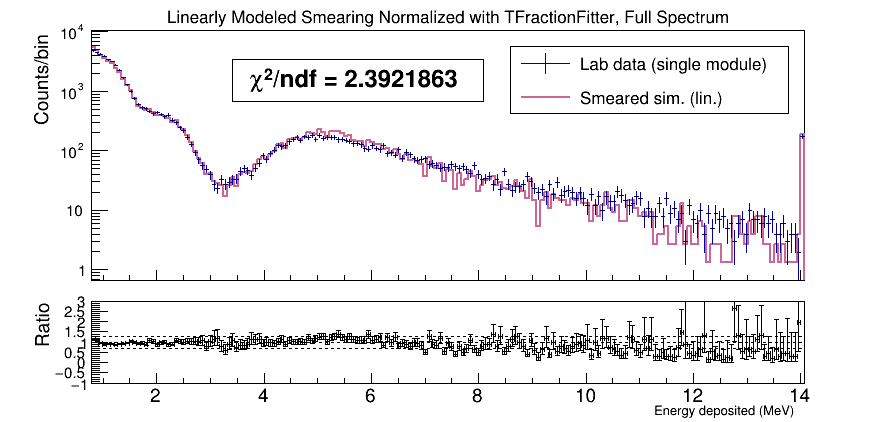

In [12]:
# Plot TRatioPlot between lab data and normalized lin. smeared sim, get new chi2/ndf

c6 = TCanvas('c6','',900,450)

gPad.SetLogy()

gStyle.SetStatFontSize(.08)
gStyle.SetTitleFontSize(0.085)
gStyle.SetStatW(0.4)

gStyle.SetPalette(kBird)

h_dat.Draw("plc pmc hist")
tots.SetTitle("Linearly Modeled Smearing Normalized with TFractionFitter, Full Spectrum")

tots.GetXaxis().SetTitle("Energy deposited (MeV)")

h_dat.SetLineWidth(1)
tots.SetLineWidth(2)

h_dat.SetAxisRange(0.8, 14, "X")
tots.SetAxisRange(0.8, 14, "X")

tots.Draw("hist same")
tots.SetLineColor(kPink+2)

c6.Clear()

rp = TRatioPlot(tots,h_dat)
rp.Draw()

rp.GetLowerRefYaxis().SetTitle("Ratio")
rp.GetUpperRefYaxis().SetTitle("Counts/bin")
rp.GetUpperRefYaxis().SetTitleOffset(0.7)
rp.GetLowerRefYaxis().SetTitleOffset(0.7)
rp.GetLowerRefYaxis().SetRangeUser(-1,3)

rp.GetLowerRefYaxis().SetLabelSize(.04)
rp.GetLowerRefYaxis().SetTitleSize(.05)
rp.GetUpperRefYaxis().SetLabelSize(.04)
rp.GetUpperRefYaxis().SetTitleSize(.05)
rp.GetLowerRefXaxis().SetLabelSize(.05)
rp.GetLowerRefXaxis().SetTitleSize(.035)

chi2 = " #chi^{2}/ndf = " + str(round(tots.Chi2Test(h_dat, "UW CHI2/NDF"), 8)) + " "

legend = TLegend(0.57,0.73,0.88,0.89)
legend.AddEntry(h_dat,"Lab data (single module)","le")
legend.AddEntry(tots,"Smeared sim. (lin.)","l")
legend.Draw()

title = TPaveText(0.26, 0.76, 0.54, 0.86, "NDC")
title.AddText(chi2)
title.SetMargin(0.05)
title.SetBorderSize(1)
title.SetFillColor(0)
title.Draw()

c6.Draw()

# c6.SaveAs("NBv5_NORMALIZED_GammasAndMuons_LinSmear_Full.png")

### ATTEMPT 3: Second degree polynomial model, fit using TMinuit (WIP)

Use TMinuit to model the energy resolution as $ \sigma^2 = c_0 + c_1 E_{PE} + c_2 E_{PE}^2 $